In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import defaultdict
from io import StringIO
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

## How much human food resources are available for African countries?

To answer to this important question, we will need to import data from **FAO Dataset**. More specifically, we will focus on the section **Food Balance Sheet** with respect for African countries only. 

In [15]:
FAO_food_balance = pd.read_csv("Data/FoodBalanceSheets_E_Africa_1.csv",encoding='latin-1');

Firstly, we will **remove** all the columns with title **"Y----F"** as they contain informations about how the data were obtained (Calculated, Regression, Aggregate, FAO Estimation). In this context we will consider that FAO is an *highly renowned Agency* and hence we can assume these values are truthful without loss of generality. Furthermore we thought that it would be very handy to have numbers as columns representing years instead of **"Y----"**. We proceed on removing the letter **Y**.

In [16]:
col_to_drop = FAO_food_balance.columns[FAO_food_balance.columns.str.endswith("F")]; #creating a list of columns to be removed
FAO_food_balance = FAO_food_balance.drop(columns=col_to_drop);
FAO_food_balance.columns=FAO_food_balance.columns.str.replace("Y","") #rename the columns by deleting "Y" at the beginning

Secondly, we replace all the **NAN** values with **0** as Item was not available.

In [17]:
FAO_food_balance = FAO_food_balance.fillna(0);

The third step to complete **the cleaning** of FAO_food_balance consists into adapt names of countries in order to have consistency along our different dataframes. Since some countries changed their name over the years we will rename them. In particular, **Swaziland** to **Eswatini** and **South Africa** to **Southern Africa**.

In [18]:
FAO_food_balance['Area'] = FAO_food_balance['Area'].replace("Swaziland", "Eswatini");
FAO_food_balance['Area'] = FAO_food_balance['Area'].replace("South Africa", "Southern Africa");

Our Dataframe looks like this:

In [19]:
FAO_food_balance.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,1961,1962,1963,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,4,Algeria,2501,Population,511,Total Population - Both sexes,1000 persons,11561.0,11845.0,12136.0,...,33461.0,33961.0,34507.0,35097.0,35725.0,36383.0,37063.0,37763.0,38482.0,39208.0
1,4,Algeria,2511,Wheat and products,5511,Production,1000 tonnes,686.0,1507.0,1590.0,...,2731.0,2415.0,2688.0,2319.0,1111.0,2953.0,2605.0,2555.0,3432.0,3299.0
2,4,Algeria,2511,Wheat and products,5611,Import Quantity,1000 tonnes,469.0,501.0,374.0,...,5123.0,5697.0,4987.0,4885.0,6508.0,5757.0,5109.0,7487.0,6385.0,6343.0
3,4,Algeria,2511,Wheat and products,5072,Stock Variation,1000 tonnes,353.0,-409.0,-408.0,...,-456.0,-606.0,-459.0,-1.0,156.0,-484.0,515.0,-1050.0,-350.0,-180.0
4,4,Algeria,2511,Wheat and products,5911,Export Quantity,1000 tonnes,46.0,12.0,33.0,...,7.0,13.0,7.0,14.0,24.0,37.0,39.0,5.0,5.0,2.0


Analysing our DataFrame *FAO_food_balance* we can see that it's already well structured since it contains many key - value couples such as **Item Code - Item** and **Element Code - Element** . More specifically, we will take advantage of this structure to filter out only rows characterized by **Grand total** as an **Item** and **Food supply (kcal/capita/day)** as an **Element**. The corresponding key-values are **(Item Code, 2901) and (Element Code, 664)**.
A reference to the documentation in the [FAO Website](http://www.fao.org/faostat/en/#data/FBS) explains extensevely the legend for Element Code and Element Item. 

In order to keep our original Dataframe *FAO_food_balance* as a reference we create a new Dataframe *FAO_food_supply* in which we keep just **countries** and **food supplies** for every **year**.

In [20]:
FAO_food_supply = FAO_food_balance[(FAO_food_balance["Item Code"] == 2901) & (FAO_food_balance["Element Code"] == 664)];
FAO_food_supply = FAO_food_supply.drop(columns=["Area Code","Item Code","Item","Element Code","Element", "Unit"])

We can now group group by **Area** and see the supplies derived from each item available in countries for that particular year.

In [21]:
FAO_food_supply = FAO_food_supply.set_index("Area")
FAO_food_supply.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,
Algeria,1619.0,1569.0,1528.0,1540.0,1591.0,1571.0,1647.0,1706.0,1705.0,1675.0,...,2987.0,2958.0,3047.0,3041.0,3048.0,3110.0,3142.0,3217.0,3272.0,3296.0
Angola,1798.0,1819.0,1853.0,1862.0,1877.0,1890.0,1921.0,1856.0,1946.0,1965.0,...,2030.0,2077.0,2119.0,2173.0,2245.0,2303.0,2345.0,2407.0,2384.0,2473.0
Benin,1736.0,1758.0,1703.0,1669.0,1812.0,1804.0,1833.0,1935.0,1871.0,1812.0,...,2461.0,2435.0,2450.0,2564.0,2521.0,2565.0,2555.0,2598.0,2610.0,2619.0
Botswana,1976.0,1909.0,1972.0,2001.0,2005.0,1947.0,2010.0,2052.0,2013.0,2035.0,...,2191.0,2198.0,2150.0,2166.0,2184.0,2199.0,2234.0,2273.0,2342.0,2326.0
Burkina Faso,1326.0,1308.0,1452.0,1555.0,1571.0,1560.0,1587.0,1602.0,1604.0,1546.0,...,2505.0,2463.0,2559.0,2546.0,2588.0,2639.0,2681.0,2664.0,2707.0,2720.0


In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [22]:
FAO_food_supply = FAO_food_supply.transpose();

In [23]:
#converting the year from string to int
FAO_food_supply.index = FAO_food_supply.index.astype(int)

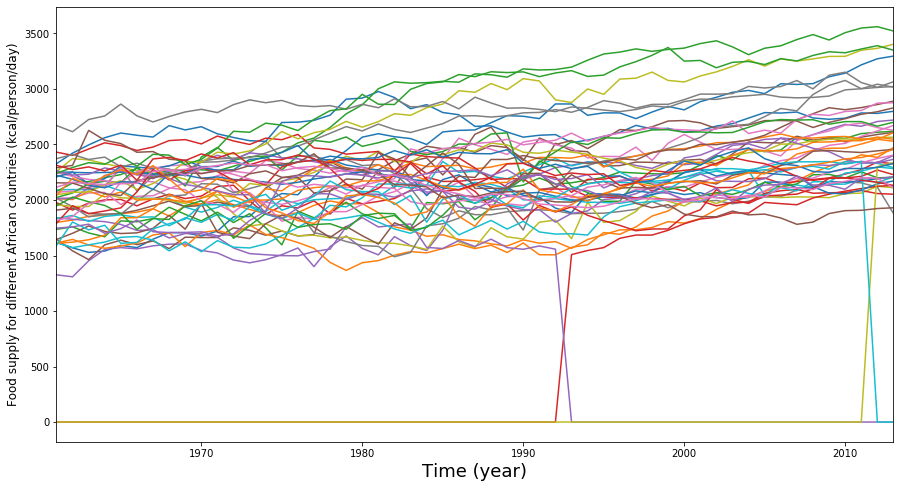

In [24]:
FAO_food_supply.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply for different African countries (kcal/person/day)", fontsize=12);

This analysis shows that there are two inconsistencies. We therefore check for countries containing values equal to zero.

In [25]:
FAO_food_supply.columns.values[(FAO_food_supply == 0).any()]

array(['Ethiopia', 'Ethiopia PDR', 'Sudan', 'Sudan (former)'],
      dtype=object)

We notice that **Sudan** and **Ethiopia** appear twice as "Sudan" and "Sudan (former)" and "Ethiopia" and "Ethiopia PDR" respectively. This is due to the fact that South Sudan gained independence in 2011 (reference to https://en.wikipedia.org/wiki/South_Sudan), and the foundation of the Federal Democratic Republic of Ethiopia (https://en.wikipedia.org/wiki/Ethiopia) in 1991. From then on, Ethiopia PDR was listed as Ethiopia. With food supply being consistently constant even after division, the newly introduced country "Sudan" is assumed to further on have accounted for both countries. For this reason, we will consider them to be one single country. 
Consequently, the two countries' data is merged into one continuous set each.

In [26]:
FAO_food_supply_cleared = FAO_food_supply.copy()
FAO_food_supply_cleared['Sudan'] += FAO_food_supply_cleared['Sudan (former)']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Sudan (former)', 1)
FAO_food_supply_cleared['Ethiopia'] += FAO_food_supply_cleared['Ethiopia PDR']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Ethiopia PDR', 1)

Let's plot the newly generated data:

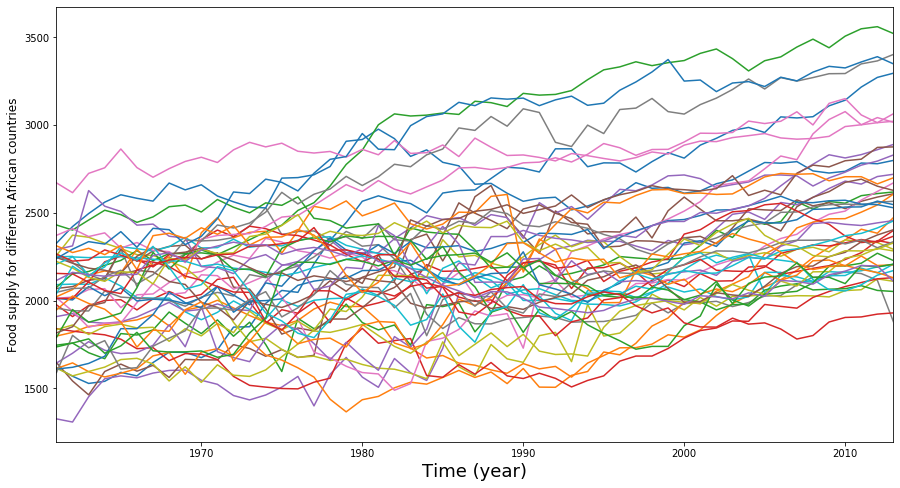

In [27]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply for different African countries", fontsize=12);

Next, we want to add more columns representing future years until 2020 to prepare cells for extrapolation to make predictions about possible scenarios.

In [28]:
FAO_food_supply_cleared = FAO_food_supply_cleared.transpose();

In [29]:
for i in np.arange(2014,2021):
    FAO_food_supply_cleared[i] = np.nan

In [30]:
FAO_food_supply_cleared = FAO_food_supply_cleared.transpose();

#### Extrapolation (To be changed)
First of all, we want to simulate data until 2020 to match the population data. Furthermore, we also want to be able to make predicitions for individual countries to assess if they might run into food shortages in the near future. For extrapolating, we are not considering value of the entire timeline, as past crisis and wars should not influence the recent trend in food supply development. We chose to restrict the extrapolation basis to the years 2000-2013 and use a linear function in order to avoid too much fluctuation, especially negative values resulting from an (exponential decay

**To be commented..**

In [31]:
from windowslider import WindowSlider
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor


w = 5
for col in FAO_food_supply_cleared.columns.values:
    years_train = FAO_food_supply_cleared.index.values[:53].copy()
    cal_train = FAO_food_supply_cleared[col][:53].values.copy()
    train_set = pd.DataFrame(cal_train, index=years_train)
    train_set.insert(0, '∆t', np.ones(train_set.index.size))
    train_set.reset_index(inplace=True)
    train_set.rename(columns={"index": "years", 0:"cal"}, inplace=True)
    train_constructor = WindowSlider(window_size=w)
    train_windows = train_constructor.collect_windows(train_set.iloc[:,1:],
                                                  previous_y=True)
    
    #forest = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, max_depth=10, random_state=0) #flat
    neigh = KNeighborsRegressor(n_neighbors = 1) #flat (less)
    #lr = LinearRegression()
    lrid = Ridge(alpha=0.1, normalize=True)
    #ada = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, loss="square") #flat
    gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=7) #zog 
    #tr = DecisionTreeRegressor() #zag
    vot = VotingRegressor([('n', neigh), ('lin', lrid), ('gbr', gbr)], weights=[0.3, 3, 0.8])
    vot.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])
    for i in range(54, 61):
        years_test = FAO_food_supply_cleared.index.values[39:i]
        cal_test = FAO_food_supply_cleared[col][39:i].values
        test_set = pd.DataFrame(cal_test, index=years_test)
        test_set.insert(0, '∆t', np.ones(test_set.index.size))
        test_set.reset_index(inplace=True)
        test_set.rename(columns={"index": "years", 0:"cal"}, inplace=True)
        test_constructor = WindowSlider(window_size=w)
        test_windows = test_constructor.collect_windows(test_set.iloc[:,1:],
                                                        previous_y=True)
        pred = vot.predict(test_windows.iloc[:,:-1])
        FAO_food_supply_cleared[col].iloc[i-1] = pred[-1]

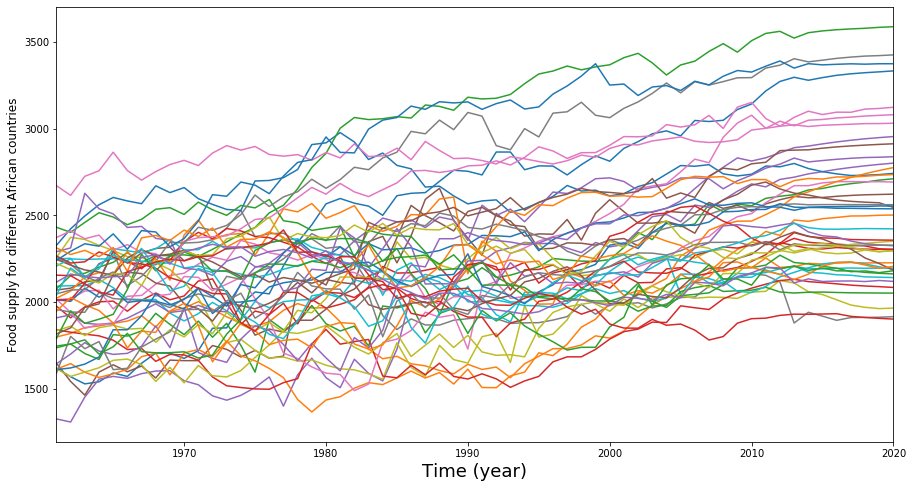

In [32]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply for different African countries", fontsize=12);

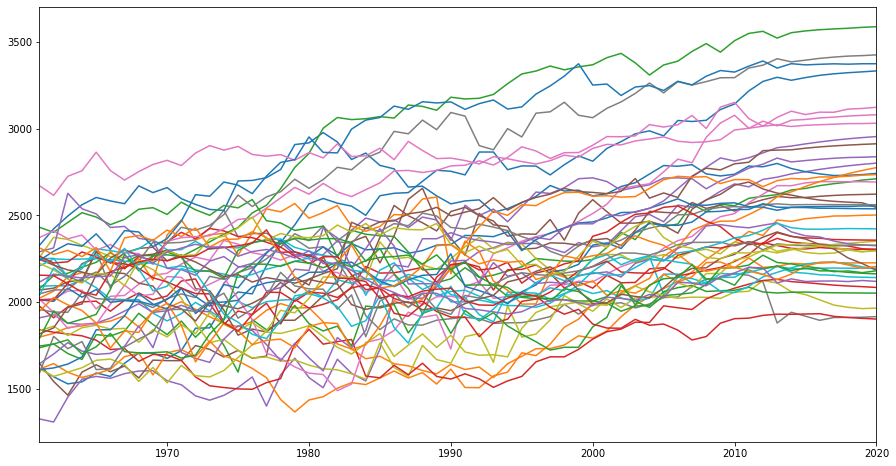

In [33]:
#linear graph, just to remember the difference for now
FAO_food_supply_cleared.plot.line(legend = False);

# What is the ideal amount of kcal each African country need?
In this first part, we decide to compute **kcal demand** for males and females for every age group. Secondly, we will assert an extensive analysis on **African demographics**. Finally, we will be able to combine kcal demand with african population data into a unique dataframe that will be the answer of our inital question.

### 1- What is the kcal demand of a regular person in order to be healthy? 
We load the calories demand datasets we scraped for the webpage [Calories](https://health.gov/dietaryguidelines/2015/guidelines/appendix-2/), datasets will we working on to match with population data

In [34]:
male_calory_demand = pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=0, names=['age', 'sedentary', 'moderate', 'active'])

In [35]:
females_calory_demand =  pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=1, names=['age', 'sedentary', 'moderate', 'active'])

In order to better work with the information we have collected, we will make some simplifications on the data. Mainly, we will:
- in the calories demands database, take the **active lifestyle** column. According to [World Health Organization](https://www.afro.who.int/health-topics/physical-activity), regular physical activity helps to maintain a healthy body and reduces the risk of disease. For this reason, we want African people to be able to embrace an active lifestyle and therefore we assume an higher amount of kCal needed
- group the ages into ranges that match the ranges provided in the World Population Database

In [36]:
male_calories_act = male_calory_demand.drop(columns=['sedentary', 'moderate'])
females_calories_act = females_calory_demand.drop(columns=['sedentary', 'moderate'])
male_calories_act.rename(columns={'active':'input kcal'}, inplace=True)
females_calories_act.rename(columns={'active':'input kcal'}, inplace=True)

We have now obtained a caloric demand for simpler calculations in the future and stored in the two precedent datasets.  
Now, we need a  way to match the age groups in this dataframe, to the ones in the population database we obtained. As such, let's analyse how ages are represented in our calory demand dataframes.

In [37]:
male_calories_act['age'].unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       '19-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50',
       '51-55', '56-60', '61-65', '66-70', '71-75', '76 and up', nan],
      dtype=object)

We can see there are ranges of ages with different sizes (which makes sense, because different age groups have different caloric needs). We'll present a function that creates one row per individual age

In [38]:
def single_age(age_range):
    if type(age_range) ==  float: # nans are the only floats in the age column
        return -1
    elif type(age_range) == int:
        return age_range
    elif re.search('\d-\d', age_range):
        group = age_range.split('-')
        return list(range(int(group[0]), int(group[1])+1))
    elif age_range == "76 and up":
        return list(range(76, 101+1))

In [39]:
def explode_age(data_frame):
    accum = []
    for i in data_frame.index:
        row = data_frame.loc[i]
        single = single_age(row['age'])
        if single == -1: # we ignore the nan values, as their rows are empty
            continue
        if type(single) == int:
            accum.append((single, row['input kcal']))
        elif type(single) == list:
            accum.extend([(x, row['input kcal']) for x in single]) 
    return pd.DataFrame(accum, columns=data_frame.columns)

We apply the function to our two dataframe:

In [40]:
male_explode = explode_age(male_calories_act)
female_explode = explode_age(females_calories_act)

In [41]:
male_explode['age'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101])

Ages are now unique in each dataframe ( `male_explode` and `female_explode` ) and there's a caloric input value for each of them.

The last step to allow the match with the population database is to build the **same age groups** we have in that set.  
We do this in the next two functions:

In [42]:
def group(age):
    i = int(5*(age//5))
    return "{}-{}".format(i, i+4)

In [43]:
def compress_ages(data_frame):
    accum = defaultdict(list)
    for i in data_frame.index:
        row = data_frame.loc[i]
        g_id = group(row['age'])
        if g_id == "100-104":
            g_id = "100+"
        accum[g_id].append(row['input kcal'])
    for i in accum:
        accum[i] = sum(accum[i]) / len(accum[i])
    return pd.DataFrame.from_dict(accum, orient='index')

We can lastly apply the functions to the dataframes:

In [44]:
new_male_need = compress_ages(male_explode)
new_female_need = compress_ages(female_explode)

We also use the age group as new index and rename the columns:

In [45]:
new_male_need.index.name = 'age_group'
new_male_need = new_male_need.rename(columns={0: 'input kcal'})
new_female_need.index.name = 'age_group'
new_female_need = new_female_need.rename(columns={0: 'input kcal'})

Let's see the result we have achieved and collected in our matchable dataframe `new_male_need` and `new_female_need`. The unit here is **kcal/persona/day**.

In [46]:
new_male_need.head()

,input kcal
age_group,
0-4,1333.333333
5-9,1840.000000
10-14,2440.000000
15-19,3120.000000
20-24,3000.000000


### 2- How many people live in Africa?

In this second part of our analysis, we load the list of **African countries**. Secondly, we load the **World Population Database** (United Nation) and therefore we obtain two dataframes: one for males and the other one for females.

In [47]:
with open ("data/african_countries.txt",'r') as af_c:
    af_countries = [line.rstrip() for line in af_c] #loading list

We need to check if the FAO Database contains data regarding **every country** in Africa. We will check the instection with the list **af_countries**.

In [48]:
af_to_remove = list(set(af_countries)- set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: ['Democratic Republic of the Congo', 'Burundi', 'Western Sahara', 'Seychelles', 'Réunion', 'Equatorial Guinea', 'Comoros', 'South Sudan', 'Libya', 'Eritrea', 'Somalia', 'Mayotte']


As expetected many countries we not present in the FAO Database. The countries we will delete are the following: **Eritrea, Burundi, Comoros, Democratic Republic of the Congo, Equatorial Guinea, Libya ,Seychelles, Western Sahara, South Sudan, and Somalia**. In particular, **Mayotte** and **Réunion** are two indipendent French islands so they will be removed as well.

In [49]:
af_countries = [i for i in af_countries if not i in af_to_remove]
af_to_remove = list(set(af_countries)- set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: "+ str(af_to_remove))

List of countries for which no data is available: []


**World Population Database** (United Nation) is now loaded and cleaned. This preprocessing is necessary in order to sort things out for next more complex steps.
**A note**: Since the population data are per 1000 people, we decide to multiply for the same factor (1000) and get back to the real number.

In [50]:
#loading datasets
pop_male = pd.read_excel("data/POPULATION_BY_AGE_MALE.xlsx", sheet_name="ESTIMATES")
pop_female = pd.read_excel("data/POPULATION_BY_AGE_FEMALE.xlsx", sheet_name="ESTIMATES")

In [51]:
#cleaning male population dataset
pop_male.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_male.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#taking only african countries
pop_male = pop_male[pop_male['country'].isin(af_countries)]

#cleaning female dataset
pop_female.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_female.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#only african
pop_female = pop_female[pop_female['country'].isin(af_countries)]

In [52]:
#take in consideration the 1000 of population from the beginning now
pop_male.iloc[:, 2:] = pop_male.iloc[:, 2:]*1000
pop_female.iloc[:, 2:] = pop_female.iloc[:, 2:]*1000

Let's have a look at the final version of male population data grouped by age:

In [55]:
pop_male.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
420,Djibouti,1950,6128,4593,3828,3247,2727,2266,1873,1538,...,589,422,277,160,74,24,7,0,0,0
421,Djibouti,1955,5556,5527,4487,3773,3168,2639,2186,1800,...,696,506,337,198,94,33,7,0,0,0
422,Djibouti,1960,7201,5360,5668,4640,3867,3218,2672,2203,...,868,631,428,256,126,46,11,0,0,0
423,Djibouti,1965,10888,7814,6324,6545,5316,4389,3642,3006,...,1191,872,591,358,179,71,16,2,0,0
424,Djibouti,1970,15553,11828,9094,7514,7519,6072,4994,4120,...,1646,1208,826,503,259,102,24,3,0,0


In this context, the population dataframe for males **pop_male** and for females **pop_female** contains measurement of population for years from 1950 to 2020 with a frequency of **5 years**, we now decide to interpolate in order to obtain values for intermediate years. 

First of all, we want to look at the data in order to undestand what is the population growth's **trend**  over the years.

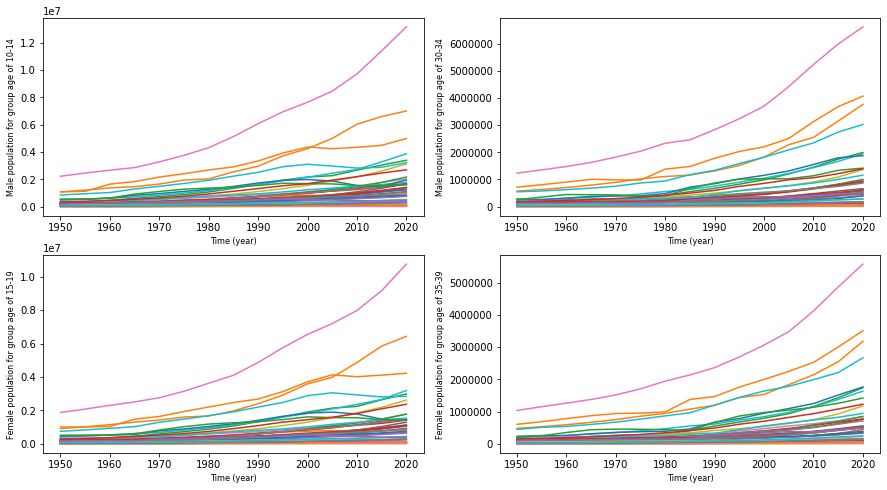

In [45]:
fig, axs = plt.subplots(2, 2)
x = pop_male.year.drop_duplicates()
for country in pop_male.country.drop_duplicates():
    y = pop_male[(pop_male.country==country)]["10-14"]    
    axs[0, 0].plot(x,y)
axs[0, 0].set_xlabel("Time (year)",fontsize=8)
axs[0, 0].set_ylabel("Male population for group age of 10-14", fontsize=8);

for country in pop_male.country.drop_duplicates():
    y = pop_male[(pop_male.country==country)]["30-34"]
    axs[0, 1].plot(x,y)
axs[0, 1].set_xlabel("Time (year)",fontsize=8)
axs[0, 1].set_ylabel("Male population for group age of 30-34", fontsize=8);


x = pop_female.year.drop_duplicates()
for country in pop_female.country.drop_duplicates():
    y = pop_female[(pop_female.country==country)]["15-19"]
    axs[1, 0].plot(x,y)
axs[1, 0].set_xlabel("Time (year)",fontsize=8)
axs[1, 0].set_ylabel("Female population for group age of 15-19", fontsize=8);

for country in pop_female.country.drop_duplicates():
    y = pop_female[(pop_female.country==country)]["35-39"]
    axs[1, 1].plot(x,y)
axs[1, 1].set_xlabel("Time (year)",fontsize=8)
axs[1, 1].set_ylabel("Female population for group age of 35-39", fontsize=8);


We can now assume that the population grows linearly over time, a plausible result is accomplished by interpolating with a linear method. The dataframe we will obtain will keep the same characteristics of the previous one with the difference of frequency that now is **1 year**.

In [147]:
coll = ['country', 'year'] 

pop_temp_m= pd.DataFrame(columns = coll )
pop_male_yearly= pd.DataFrame(columns = coll )
for country in pop_male.country.drop_duplicates():
    for ages in pop_male.columns[2:]:
        x = pop_male.year.drop_duplicates()
        y = pop_male[(pop_male.country==country)][ages].astype(float)
        xnew = np.arange(1950,2021)
        ynew = np.interp(xnew, x, y, left=None, right=None, period=None)
        pop_temp_m[ages] = ynew
        pop_temp_m["country"]=country
        pop_temp_m["year"]=Xtest  
    pop_male_yearly = pop_male_yearly.append(pop_temp_m, sort=False)


    
pop_temp_f= pd.DataFrame(columns = coll )
pop_female_yearly= pd.DataFrame(columns = coll )
for country in pop_female.country.drop_duplicates():
    for ages in pop_female.columns[2:]:
        x = pop_female.year.drop_duplicates()
        y = pop_female[(pop_female.country==country)][ages].astype(float)
        xnew = np.arange(1950,2021)
        ynew = np.interp(xnew, x, y, left=None, right=None, period=None)
        pop_temp_f[ages] = ynew
        pop_temp_f["country"]=country
        pop_temp_f["year"]=Xtest  
    pop_female_yearly = pop_female_yearly.append(pop_temp_f, sort=False)

Let's see how the new dataframes for males and females population look like:

In [148]:
pop_male_yearly.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,6128.0,4593.0,3828.0,3247.0,2727.0,2266.0,1873.0,1538.0,...,589.0,422.0,277.0,160.0,74.0,24.0,7.0,0.0,0.0,0.0
1,Djibouti,1951,6013.6,4779.8,3959.8,3352.2,2815.2,2340.6,1935.6,1590.4,...,610.4,438.8,289.0,167.6,78.0,25.8,7.0,0.0,0.0,0.0
2,Djibouti,1952,5899.2,4966.6,4091.6,3457.4,2903.4,2415.2,1998.2,1642.8,...,631.8,455.6,301.0,175.2,82.0,27.6,7.0,0.0,0.0,0.0
3,Djibouti,1953,5784.8,5153.4,4223.4,3562.6,2991.6,2489.8,2060.8,1695.2,...,653.2,472.4,313.0,182.8,86.0,29.4,7.0,0.0,0.0,0.0
4,Djibouti,1954,5670.4,5340.2,4355.2,3667.8,3079.8,2564.4,2123.4,1747.6,...,674.6,489.2,325.0,190.4,90.0,31.2,7.0,0.0,0.0,0.0


In [149]:
pop_female_yearly.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,6065.0,4583.0,3819.0,3238.0,2736.0,2295.0,1911.0,1574.0,...,655.0,487.0,334.0,202.0,100.0,34.0,11.0,2.0,0.0,0.0
1,Djibouti,1951,5948.6,4764.2,3949.6,3342.8,2824.4,2369.8,1973.8,1627.2,...,679.0,505.8,347.6,211.2,105.4,37.0,11.0,2.0,0.0,0.0
2,Djibouti,1952,5832.2,4945.4,4080.2,3447.6,2912.8,2444.6,2036.6,1680.4,...,703.0,524.6,361.2,220.4,110.8,40.0,11.0,2.0,0.0,0.0
3,Djibouti,1953,5715.8,5126.6,4210.8,3552.4,3001.2,2519.4,2099.4,1733.6,...,727.0,543.4,374.8,229.6,116.2,43.0,11.0,2.0,0.0,0.0
4,Djibouti,1954,5599.4,5307.8,4341.4,3657.2,3089.6,2594.2,2162.2,1786.8,...,751.0,562.2,388.4,238.8,121.6,46.0,11.0,2.0,0.0,0.0


### 3- Estimantion of ideal human food demand in Africa 

Now we multiply each column of the population data for each matching `age_group` in the calories table (that here we squeeze to allow the multiplication, similar to a transpose rows/columns of the dataset).  
We obtain two datasets: `total_cal_male` and `total_cal_female` reporting total calories needed for **each country in each year per age group per gender**. 
The unit here is **kcal/day**.

In [257]:
#total calories male
pop_mal_mult = pop_male_yearly.drop(columns=["country", "year"])
total_cal_male = pop_mal_mult.multiply(new_male_need.squeeze()) # squeeze adapts the dimension of the dataframe
total_cal_male.insert(0,"country",pop_male_yearly.country)
total_cal_male.insert(1,"year",pop_male_yearly.year)
total_cal_male.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,8.170667e+06,8451120.0,9340320.0,10130640.0,8181000.0,6798000.0,5619000.0,4367920.0,...,1554960.0,1097200.0,720200.0,416000.0,180560.0,57600.0,16800.0,0.0,0.0,0.0
1,Djibouti,1951,8.018133e+06,8794832.0,9661912.0,10458864.0,8445600.0,7021800.0,5806800.0,4516736.0,...,1611456.0,1140880.0,751400.0,435760.0,190320.0,61920.0,16800.0,0.0,0.0,0.0
2,Djibouti,1952,7.865600e+06,9138544.0,9983504.0,10787088.0,8710200.0,7245600.0,5994600.0,4665552.0,...,1667952.0,1184560.0,782600.0,455520.0,200080.0,66240.0,16800.0,0.0,0.0,0.0
3,Djibouti,1953,7.713067e+06,9482256.0,10305096.0,11115312.0,8974800.0,7469400.0,6182400.0,4814368.0,...,1724448.0,1228240.0,813800.0,475280.0,209840.0,70560.0,16800.0,0.0,0.0,0.0
4,Djibouti,1954,7.560533e+06,9825968.0,10626688.0,11443536.0,9239400.0,7693200.0,6370200.0,4963184.0,...,1780944.0,1271920.0,845000.0,495040.0,219600.0,74880.0,16800.0,0.0,0.0,0.0


In [258]:
#total calories female
pop_fem_mult = pop_female_yearly.drop(columns=["country", "year"])
total_cal_female = pop_fem_mult.multiply(new_female_need.squeeze()) # squeeze adapts the dimension of the dataframe
total_cal_female.insert(0,"country",pop_male_yearly.country)
total_cal_female.insert(1,"year",pop_male_yearly.year)
total_cal_female.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,7.682333e+06,7882760.0,8249040.0,7771200.0,6566400.0,5508000.0,4280640.0,3462800.0,...,1441000.0,993480.0,668000.0,404000.0,200000.0,68000.0,22000.0,4000.0,0.0,0.0
1,Djibouti,1951,7.534893e+06,8194424.0,8531136.0,8022720.0,6778560.0,5687520.0,4421312.0,3579840.0,...,1493800.0,1031832.0,695200.0,422400.0,210800.0,74000.0,22000.0,4000.0,0.0,0.0
2,Djibouti,1952,7.387453e+06,8506088.0,8813232.0,8274240.0,6990720.0,5867040.0,4561984.0,3696880.0,...,1546600.0,1070184.0,722400.0,440800.0,221600.0,80000.0,22000.0,4000.0,0.0,0.0
3,Djibouti,1953,7.240013e+06,8817752.0,9095328.0,8525760.0,7202880.0,6046560.0,4702656.0,3813920.0,...,1599400.0,1108536.0,749600.0,459200.0,232400.0,86000.0,22000.0,4000.0,0.0,0.0
4,Djibouti,1954,7.092573e+06,9129416.0,9377424.0,8777280.0,7415040.0,6226080.0,4843328.0,3930960.0,...,1652200.0,1146888.0,776800.0,477600.0,243200.0,92000.0,22000.0,4000.0,0.0,0.0


Once we have the calories needed for both gender, we can add them together easily to achieve total calories needed for **each country in each year per age group**, and we collect them in the dataframe `total_cal_ages`. The unit is still **kcal/day**.

In [259]:
#copy the male inside the total (to mantain country and year columns) and sum with female
total_cal_ages = total_cal_male.copy()
sum_ind = total_cal_ages.columns[2:]
total_cal_ages[sum_ind] = total_cal_ages[sum_ind] + total_cal_female[sum_ind]
total_cal_ages.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Djibouti,1950,1.585300e+07,16333880.0,17589360.0,17901840.0,14747400.0,12306000.0,9899640.0,7830720.0,...,2995960.0,2090680.0,1388200.0,820000.0,380560.0,125600.0,38800.0,4000.0,0.0,0.0
1,Djibouti,1951,1.555303e+07,16989256.0,18193048.0,18481584.0,15224160.0,12709320.0,10228112.0,8096576.0,...,3105256.0,2172712.0,1446600.0,858160.0,401120.0,135920.0,38800.0,4000.0,0.0,0.0
2,Djibouti,1952,1.525305e+07,17644632.0,18796736.0,19061328.0,15700920.0,13112640.0,10556584.0,8362432.0,...,3214552.0,2254744.0,1505000.0,896320.0,421680.0,146240.0,38800.0,4000.0,0.0,0.0
3,Djibouti,1953,1.495308e+07,18300008.0,19400424.0,19641072.0,16177680.0,13515960.0,10885056.0,8628288.0,...,3323848.0,2336776.0,1563400.0,934480.0,442240.0,156560.0,38800.0,4000.0,0.0,0.0
4,Djibouti,1954,1.465311e+07,18955384.0,20004112.0,20220816.0,16654440.0,13919280.0,11213528.0,8894144.0,...,3433144.0,2418808.0,1621800.0,972640.0,462800.0,166880.0,38800.0,4000.0,0.0,0.0


To find the total calories needed for **each country in each year** we then proceed to the sum over all the age groups, collected in `total_cal`. The unit is still **kcal/day**.

In [260]:
total_cal = total_cal_ages.copy()
sum_ind = total_cal.columns[2:]

#computing sum of cal over ages, removing ages
total_cal['Calories'] = total_cal[sum_ind].sum(axis=1)
total_cal.drop(columns=sum_ind, inplace=True)

Last step of the calculation is top convert the values from **kcal/day** to **kcal/year**. The factor is **365**. In this way, we have obtained overall values of kcal that each country neeeded from 1950 to 2020.

In [261]:
change_col = total_cal_ages.columns[2:] #index for the first 3 dataframes are the same
total_cal_male[change_col] = total_cal_male[change_col]*365
total_cal_female[change_col] = total_cal_male[change_col]*365
total_cal_ages[change_col] = total_cal_male[change_col]*365
total_cal['Calories'] = total_cal['Calories']*365

Let's take a look at total calories dataframe **total_cal**:

In [262]:
total_cal.sort_values(by="Calories").head()
total_cal = total_cal.reset_index()

For the sake of consistency, we will now reshape our dataframe **total_cal** according to the same schema seen for **FAO_food_supply_cleared**. 

In [263]:
#We sort values by year, we group them by country and we tranpose the values in columns Calories.
#In the function lambda we reset the index. The unstack() allows to return a new dataframe with 
#a new level of columns.

years = list(total_cal.year.drop_duplicates().sort_values())
total_cal = total_cal.sort_values('year').groupby("country")['Calories'].apply(lambda df: df.reset_index(drop=True)).unstack()
total_cal.columns = years
total_cal.index.name = 'Country'

Drawing a sample of the final shaped dataframe total calories **total_cal**:

In [264]:
total_cal.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Algeria,7.290425e+12,7.412354e+12,7.534284e+12,7.656213e+12,7.778143e+12,7.900072e+12,8.092341e+12,8.284610e+12,8.476879e+12,8.669149e+12,...,3.150748e+13,3.205546e+13,3.260345e+13,3.315144e+13,3.369942e+13,3.433776e+13,3.497610e+13,3.561444e+13,3.625278e+13,3.689112e+13
Angola,3.721975e+12,3.797306e+12,3.872637e+12,3.947968e+12,4.023299e+12,4.098630e+12,4.159526e+12,4.220422e+12,4.281318e+12,4.342214e+12,...,1.941009e+13,2.013902e+13,2.086796e+13,2.159689e+13,2.232582e+13,2.315305e+13,2.398027e+13,2.480750e+13,2.563473e+13,2.646195e+13
Benin,1.851458e+12,1.858390e+12,1.865323e+12,1.872255e+12,1.879187e+12,1.886119e+12,1.905149e+12,1.924180e+12,1.943210e+12,1.962241e+12,...,7.691320e+12,7.921509e+12,8.151697e+12,8.381886e+12,8.612074e+12,8.874543e+12,9.137011e+12,9.399479e+12,9.661947e+12,9.924415e+12
Botswana,3.377080e+11,3.450761e+11,3.524442e+11,3.598122e+11,3.671803e+11,3.745484e+11,3.799093e+11,3.852703e+11,3.906313e+11,3.959923e+11,...,1.688976e+12,1.709664e+12,1.730351e+12,1.751039e+12,1.771726e+12,1.812568e+12,1.853409e+12,1.894250e+12,1.935091e+12,1.975932e+12
Burkina Faso,3.538834e+12,3.574675e+12,3.610516e+12,3.646357e+12,3.682198e+12,3.718039e+12,3.765608e+12,3.813178e+12,3.860748e+12,3.908317e+12,...,1.296491e+13,1.338135e+13,1.379779e+13,1.421422e+13,1.463066e+13,1.510462e+13,1.557857e+13,1.605253e+13,1.652648e+13,1.700044e+13


Let's go on with a quick visualization of the data in order to understand the trend over countries

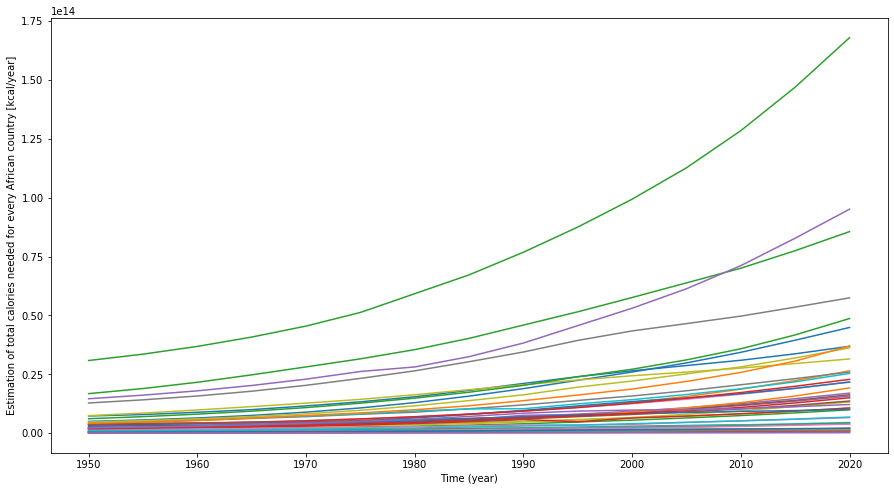

In [282]:
plt.plot(total_cal.T);
plt.xlabel('Time (year)')
plt.ylabel('Estimation of total calories needed for every African country [kcal/year]');

# Which countries do we have to do to help then? 
It follows an interisting comparison between two dataframe we have obtained in the fist part of our analysis. More specifically, the analysis will start 

In [283]:
FAO_food_supply_cleared = FAO_food_supply_cleared.transpose()
FAO_food_supply_cleared = (FAO_food_supply_cleared*365)

In [284]:
FAO_food_supply_cleared.columns = FAO_food_supply_cleared.columns.values.astype(int)

ValueError: invalid literal for int() with base 10: 'Algeria'

In [255]:
pop_tot = pop_male.copy()
pop_tot.iloc[:, 2:] = pop_tot.iloc[:, 2:] + pop_female.iloc[:, 2:]
sum_ind = pop_tot.columns[2:]
pop_tot['Population'] = pop_tot[sum_ind].sum(axis=1)
pop_tot.drop(columns=sum_ind, inplace=True)

In [256]:
years = list(pop_tot.year.drop_duplicates().sort_values())
pop_tot = pop_tot.sort_values('year').groupby("country")['Population'].apply(lambda df: df.reset_index(drop=True)).unstack()
pop_tot.columns = years
pop_tot.index.name = 'Country'

In [607]:
pop_tot.head()

,1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
Country,,,,,,,,,,,,,,,
Algeria,8872250.0,9774280.0,11057864.0,12550880.0,14464992.0,16607706.0,19221659.0,22431507.0,25758872.0,28757788.0,31042238.0,33149720.0,35977451.0,39728020.0,43851043.0
Angola,4548021.0,5043251.0,5454938.0,5770573.0,5890360.0,7023994.0,8341290.0,9961993.0,11848385.0,13945205.0,16395477.0,19433604.0,23356247.0,27884380.0,32866268.0
Benin,2255222.0,2303592.0,2431617.0,2632361.0,2912338.0,3265167.0,3717161.0,4278502.0,4978489.0,5905552.0,6865946.0,7982223.0,9199254.0,10575962.0,12123198.0
Botswana,412541.0,463353.0,502733.0,559996.0,627714.0,741346.0,897860.0,1069585.0,1286756.0,1469173.0,1643333.0,1799077.0,1987106.0,2120716.0,2351625.0
Burkina Faso,4284455.0,4517155.0,4829289.0,5174874.0,5624592.0,6154554.0,6822837.0,7727908.0,8811033.0,10089880.0,11607951.0,13421935.0,15605211.0,18110616.0,20903278.0


In [608]:
pop_tot_5 = pop_tot.iloc[:, 3:]

In [609]:
pop_tot_5.head(15)

,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
Country,,,,,,,,,,,,
Algeria,12550880.0,14464992.0,16607706.0,19221659.0,22431507.0,25758872.0,28757788.0,31042238.0,33149720.0,35977451.0,39728020.0,43851043.0
Angola,5770573.0,5890360.0,7023994.0,8341290.0,9961993.0,11848385.0,13945205.0,16395477.0,19433604.0,23356247.0,27884380.0,32866268.0
Benin,2632361.0,2912338.0,3265167.0,3717161.0,4278502.0,4978489.0,5905552.0,6865946.0,7982223.0,9199254.0,10575962.0,12123198.0
Botswana,559996.0,627714.0,741346.0,897860.0,1069585.0,1286756.0,1469173.0,1643333.0,1799077.0,1987106.0,2120716.0,2351625.0
Burkina Faso,5174874.0,5624592.0,6154554.0,6822837.0,7727908.0,8811033.0,10089880.0,11607951.0,13421935.0,15605211.0,18110616.0,20903278.0
Cabo Verde,230421.0,268633.0,270240.0,283848.0,311668.0,337953.0,386288.0,428178.0,463034.0,492644.0,524740.0,555988.0
Cameroon,5773538.0,6519754.0,7451057.0,8621409.0,10070806.0,11780086.0,13599984.0,15513944.0,17733408.0,20341236.0,23298376.0,26545864.0
Central African Republic,1639706.0,1811157.0,1958367.0,2199359.0,2542170.0,2806740.0,3222662.0,3640421.0,4038380.0,4386765.0,4493171.0,4829764.0
Chad,3309583.0,3643608.0,4088568.0,4514427.0,5095400.0,5963250.0,7010159.0,8355654.0,10096630.0,11952134.0,14110971.0,16425859.0


In [610]:
FAO_food_suppl_5 = FAO_food_supply_cleared.loc[:, 1965:2020:5]

In [611]:
FAO_food_suppl_5.head(15)

,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
Area,,,,,,,,,,,,
Algeria,580715.0,611375.0,751170.0,936590.0,953745.0,1005210.0,1016525.0,1026380.0,1079670.0,1146830.0,1.202389e+06,1.216461e+06
Angola,685105.0,717225.0,678170.0,717955.0,615755.0,598965.0,615755.0,654080.0,758105.0,855925.0,9.054314e+05,9.131103e+05
Benin,661380.0,661380.0,582540.0,684375.0,717590.0,778910.0,804095.0,819425.0,888775.0,932575.0,9.690837e+05,9.894356e+05
Botswana,731825.0,742775.0,711020.0,717225.0,790955.0,808840.0,798620.0,759200.0,802270.0,815410.0,8.417017e+05,8.413084e+05
Burkina Faso,573415.0,564290.0,550055.0,570860.0,630720.0,801540.0,853005.0,846070.0,898995.0,978565.0,1.004377e+06,1.022325e+06
Cabo Verde,597870.0,606630.0,628165.0,765770.0,812490.0,864320.0,841325.0,860670.0,918705.0,921260.0,9.499127e+05,9.568685e+05
Cameroon,715400.0,790590.0,851910.0,820520.0,763215.0,742410.0,747520.0,772340.0,843515.0,916150.0,9.807773e+05,9.825587e+05
Central African Republic,837675.0,854100.0,867240.0,843150.0,671965.0,694960.0,686565.0,723795.0,739490.0,789860.0,7.000327e+05,6.992306e+05
Chad,838405.0,771245.0,628530.0,597140.0,644225.0,601520.0,656270.0,710655.0,742410.0,750805.0,7.456426e+05,7.171834e+05


In [612]:
FAO_food_supply_final = pop_tot_5.multiply(FAO_food_suppl_5)

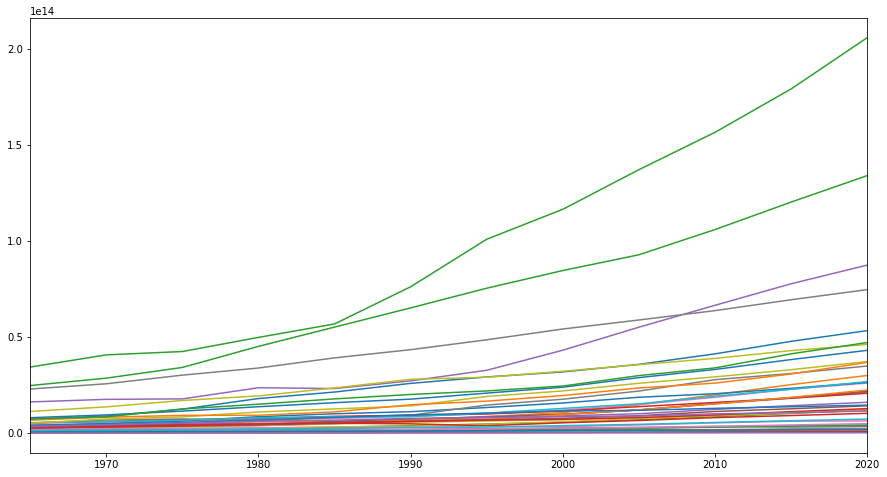

In [613]:
FAO_food_supply_final.transpose().plot(legend=False);

In [614]:
FAO_food_supply_final.head()

,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
Algeria,7.288484e+12,8.843534e+12,1.247521e+13,1.800281e+13,2.139394e+13,2.589308e+13,2.923301e+13,3.186113e+13,3.579076e+13,4.126002e+13,4.776855e+13,5.334307e+13
Angola,3.953448e+12,4.224713e+12,4.763462e+12,5.988671e+12,6.134147e+12,7.096768e+12,8.586830e+12,1.072395e+13,1.473271e+13,1.999120e+13,2.524739e+13,3.001053e+13
Benin,1.740991e+12,1.926162e+12,1.902090e+12,2.543932e+12,3.070210e+12,3.877795e+12,4.748625e+12,5.626128e+12,7.094400e+12,8.578994e+12,1.024899e+13,1.199512e+13
Botswana,4.098191e+11,4.662503e+11,5.271118e+11,6.439676e+11,8.459936e+11,1.040780e+12,1.173311e+12,1.247618e+12,1.443346e+12,1.620306e+12,1.785010e+12,1.978442e+12
Burkina Faso,2.967350e+12,3.173901e+12,3.385343e+12,3.894885e+12,4.874146e+12,7.062395e+12,8.606718e+12,9.821139e+12,1.206625e+13,1.527071e+13,1.818988e+13,2.136995e+13


In [615]:
FAO_food_supply_final = FAO_food_supply_final.dropna(axis=1)
FAO_food_supply_final.head()

,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
Algeria,7.288484e+12,8.843534e+12,1.247521e+13,1.800281e+13,2.139394e+13,2.589308e+13,2.923301e+13,3.186113e+13,3.579076e+13,4.126002e+13,4.776855e+13,5.334307e+13
Angola,3.953448e+12,4.224713e+12,4.763462e+12,5.988671e+12,6.134147e+12,7.096768e+12,8.586830e+12,1.072395e+13,1.473271e+13,1.999120e+13,2.524739e+13,3.001053e+13
Benin,1.740991e+12,1.926162e+12,1.902090e+12,2.543932e+12,3.070210e+12,3.877795e+12,4.748625e+12,5.626128e+12,7.094400e+12,8.578994e+12,1.024899e+13,1.199512e+13
Botswana,4.098191e+11,4.662503e+11,5.271118e+11,6.439676e+11,8.459936e+11,1.040780e+12,1.173311e+12,1.247618e+12,1.443346e+12,1.620306e+12,1.785010e+12,1.978442e+12
Burkina Faso,2.967350e+12,3.173901e+12,3.385343e+12,3.894885e+12,4.874146e+12,7.062395e+12,8.606718e+12,9.821139e+12,1.206625e+13,1.527071e+13,1.818988e+13,2.136995e+13


In [616]:
x = (total_cal - FAO_food_supply_final)/365

In [617]:
x.dropna(axis=1)

,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
Country,,,,,,,,,,,,
Algeria,7.420501e+09,7.450208e+09,2.275014e+09,-6.988347e+09,-8.884748e+09,-1.313046e+10,-1.438612e+10,-1.471497e+10,-1.939535e+10,-2.822063e+10,-3.854555e+10,-4.507383e+10
Angola,1.922047e+09,1.458477e+09,2.409171e+09,1.917011e+09,5.005975e+09,6.471577e+09,7.006017e+09,6.606552e+09,2.310767e+09,-3.589154e+09,-8.004303e+09,-9.722128e+09
Benin,1.063408e+09,1.143622e+09,1.960362e+09,1.171612e+09,9.507517e+08,2.778310e+08,-2.829939e+07,-2.761697e+08,-1.751799e+09,-3.062637e+09,-4.484707e+09,-5.673175e+09
Botswana,9.432215e+07,8.366253e+07,1.656499e+08,1.760001e+08,7.974865e+06,-5.834536e+06,8.371554e+07,3.273515e+08,1.728591e+08,1.314593e+08,-3.639440e+07,-6.875944e+06
Burkina Faso,3.415704e+09,3.779712e+09,4.312383e+09,4.287200e+09,3.509135e+09,-1.165417e+08,-1.494812e+09,-1.447704e+09,-3.557806e+09,-7.458199e+09,-9.751290e+09,-1.197126e+10
Cabo Verde,1.187466e+08,1.338173e+08,1.226581e+08,2.435150e+07,-1.058809e+07,-6.376462e+07,-4.096152e+07,-5.017178e+07,-1.026003e+08,-9.119850e+07,-1.336338e+08,-1.487235e+08
Cameroon,1.554364e+09,3.385851e+08,-9.416346e+08,-4.195777e+08,1.005974e+09,1.845645e+09,2.090000e+09,1.584462e+09,-1.518332e+09,-5.730369e+09,-1.053067e+10,-1.177362e+10
Central African Republic,-1.006467e+08,-2.005256e+08,-3.045237e+08,-1.935887e+08,9.663619e+08,8.590974e+08,1.093597e+09,8.805590e+08,8.034149e+08,2.699728e+08,1.378633e+09,1.594749e+09
Chad,-2.647901e+08,3.740444e+08,1.968992e+09,2.505502e+09,2.126695e+09,3.152820e+09,2.621411e+09,1.863862e+09,1.399991e+09,1.488996e+09,2.141079e+09,4.021873e+09


In [618]:
x1 = x.div(pop_tot_5)

In [621]:
x1 = x1.dropna(axis=1)

In [628]:
x1[x1[2020]>0]

,1965,1970,1975,1980,1985,1990,1995,2000,2005,2010,2015,2020
Country,,,,,,,,,,,,
Central African Republic,-61.380949,-110.716862,-155.498804,-88.020493,380.132681,306.083699,339.345958,241.883847,198.944854,61.542567,306.828486,330.191944
Chad,-80.007076,102.657689,481.584691,554.998881,417.375379,528.708296,373.944515,223.065990,138.659235,124.579910,151.731524,244.850067
Congo,128.593798,310.674648,192.254854,127.927027,77.099358,219.841886,255.834523,63.349694,197.642657,96.834197,66.266909,122.550545
Ethiopia,437.941955,516.353419,703.901600,350.142407,627.205137,634.382183,622.621425,409.417073,222.824467,144.481299,138.051289,183.008663
Kenya,-139.803653,-134.858766,-150.027351,-130.408869,-16.507702,140.675302,159.453046,176.452361,70.638946,78.212468,68.726569,90.833070
Liberia,62.370816,-175.301690,-66.984756,-283.930222,-238.568245,44.762950,238.024805,107.124118,65.510192,31.489175,24.765957,34.987663
Madagascar,-289.835358,-307.333801,-347.328081,-229.543633,-180.185647,16.728500,182.052512,202.741538,158.102921,165.619189,193.138605,210.480883
Namibia,-31.090929,18.008079,58.158184,-71.066359,80.225925,154.165135,195.071541,1.249090,30.561236,225.900999,57.177646,89.178729
Rwanda,239.445100,-100.749959,-109.195269,-181.522612,-148.509666,354.162717,451.275081,369.571698,205.843741,49.474849,49.601239,81.104155


**Per Riccardo**
- Ho cambiato la moltiplicazione facendola direttamente sui 5 anni solo mentre cercavo l'errore ma dovrebbe funzionare anche senza fare quel lavoro, ho solo paure non matchi bene. Controlla in caso.
- La Côte d'Ivoire esce nella moltiplicazione ma l'abbiamo levata dai dati delle nazioni unite, quindi nel FAO c'è mi sa. Penso si possa riaggiungere
- Ci sono i grafici da commentare, nella mia parte ci sono i commenti su GCal e cazzate varie da rivedere. Riguardo alle moltiplicazioni: quella x1000 è fatta direttamente sulla popolazione prima di tutto, quella x365 è fatta alla fine sulle calorie
- Ho cambiato come facevi la popolazione totale